In [1]:
# %pip install astropy
# %pip install scipy
# %pip install matplotlib
# %pip install astroquery
# %pip install skyfield

In [2]:
import numpy as np
import astropy.io.fits as fits
import matplotlib.pyplot as plt
from datetime import datetime, timezone, timedelta

from synthetic_image import (
    get_star_catalog,
    build_synthetic_wcs,
    world_to_pixel,
    mag_to_flux,
    add_psf_to_image,
    make_gaussian_psf,
    make_moffat_psf,
    sky_brightness_to_electrons,
    add_satellite_substepping,
    add_star_trails_skyfield,
    add_star_trails_fixed_camera
)
from skyfield.api import load, wgs84, Star

In [3]:
# Basic parameters
image_width = 4144
image_height = 2822

ra_center = 88.29533   # degrees
dec_center = -5.364887 # degrees
rotation_degrees = -52.0

max_mag = 15.5
seeing_arcsec = 5.5
pixscale_arcsec = 0.495

# Fictional camera/telescope parameters
aperture_area      = 324.29  # cm^2
quantum_efficiency = 0.800
exposure_time      = 2.0     # seconds
sky_mag_per_arcsec2 = 18.5   # mag/arcsec^2
mag_zero_point     = 15.5

In [4]:
# (Optional) If we want a final WCS matching the RA/Dec center and rotation:
wcs_obj, wcs_header = build_synthetic_wcs(
    image_width,
    image_height,
    ra_center,
    dec_center,
    pixscale_arcsec=pixscale_arcsec,
    rotation_degrees=rotation_degrees
)

In [5]:
# Create an empty image
synthetic_image = np.zeros((image_height, image_width), dtype=float)

In [6]:
# Increase search radius to 2.0 deg to find more stars
star_catalog = get_star_catalog(ra_center, dec_center, radius=2.0, max_mag=max_mag)
if star_catalog is None or len(star_catalog) == 0:
    print('No stars returned by catalog query. You may need to use a brighter max_mag or larger radius.')
else:
    print(f'Successfully retrieved {len(star_catalog)} stars.')
fwhm_pixels = seeing_arcsec / pixscale_arcsec

Successfully retrieved 10427 stars.


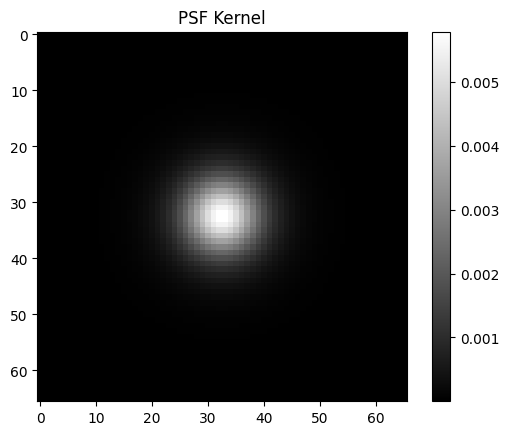

In [7]:
# Create a Moffat PSF
psf_kernel = make_moffat_psf(
    size=int(fwhm_pixels * 6),
    fwhm=fwhm_pixels,
    moffat_alpha=4
)
plt.imshow(psf_kernel, cmap='gray')
plt.colorbar()
plt.title('PSF Kernel')
plt.show()

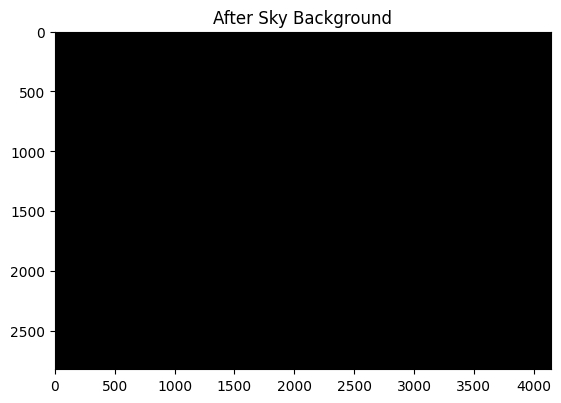

In [8]:
# Add sky background
sky_bg = sky_brightness_to_electrons(
    sky_mag_per_arcsec2,
    plate_scale_arcsec_per_pix=pixscale_arcsec,
    exposure_time=exposure_time,
    quantum_efficiency=quantum_efficiency,
    aperture_area=aperture_area,
    mag_zero_point=mag_zero_point
)
synthetic_image += sky_bg
plt.imshow(synthetic_image, cmap='gray')
plt.title('After Sky Background')
plt.show()

In [9]:
# Suppose we have a 600s exposure, but shift it to a different time so the star might be above horizon.
# For example, pick ~2025-01-10 09:00 UTC to see if that lifts the star above horizon.
start_time = datetime(2025, 1, 10, 9, 0, 0, tzinfo=timezone.utc)
end_time = start_time + timedelta(seconds=exposure_time)
num_sub_steps = 20

# 1) Compute alt0, az0 that correspond to the RA/Dec center at start_time.
ts = load.timescale()
t0 = ts.from_datetime(start_time)
planets = load('de421.bsp')
earth = planets['earth']
site = earth + wgs84.latlon(34.05, -118.25, elevation_m=100.0)  # LA area, example
center_star = Star(ra_hours=ra_center/15.0, dec_degrees=dec_center)
app_center = site.at(t0).observe(center_star).apparent()
alt_center, az_center, dist_center = app_center.altaz()
alt0_guess = alt_center.degrees
az0_guess  = az_center.degrees
print(f'Computed alt0={alt0_guess:.2f}°, az0={az0_guess:.2f}° at start time')

Computed alt0=36.53°, az0=230.14° at start time


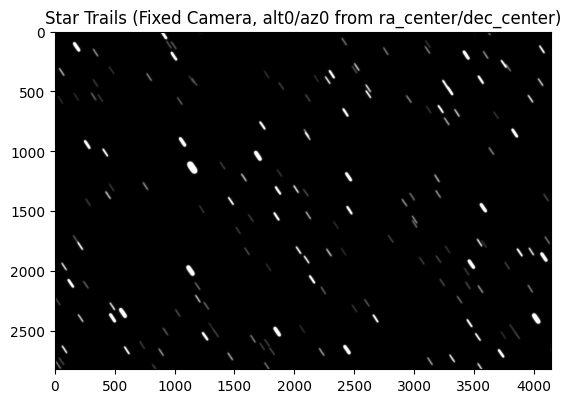

In [10]:
# 2) Use alt0_guess, az0_guess in add_star_trails_fixed_camera
if star_catalog is not None and len(star_catalog) > 0:
    add_star_trails_fixed_camera(
        image=synthetic_image,
        star_catalog=star_catalog,
        lat_deg=34.05,
        lon_deg=-118.25,
        alt_m=100.0,
        start_time=start_time,
        end_time=end_time,
        num_sub_steps=num_sub_steps,
        aperture_area=aperture_area,
        quantum_efficiency=quantum_efficiency,
        mag_zero_point=mag_zero_point,
        psf_kernel=psf_kernel,
        extinction=0.5,
        camera_rotation_deg=-90.0,
        arcsec_per_pix=pixscale_arcsec,
        alt0=alt0_guess,
        az0=az0_guess
    )
    plt.imshow(synthetic_image, cmap='gray', vmin=np.percentile(synthetic_image, 0.5), vmax=np.percentile(synthetic_image, 99.5))
    plt.title('Star Trails (Fixed Camera, alt0/az0 from ra_center/dec_center)')
    plt.show()
else:
    print('Skipping star trails because no star_catalog data was returned.')

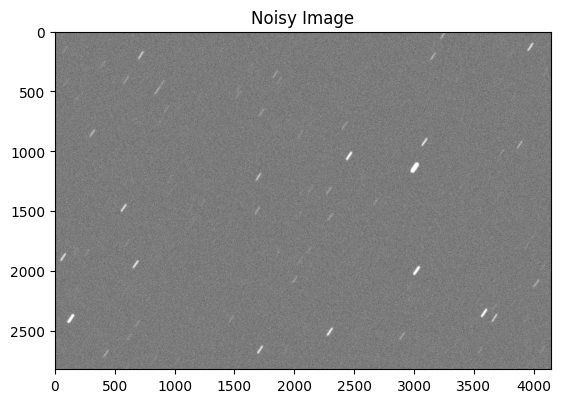

In [11]:
# Optional: Add noise
read_noise_e = 5.0
noisy_image = np.random.poisson(synthetic_image) + np.random.normal(loc=0.0, scale=read_noise_e, size=synthetic_image.shape)
noisy_image = np.fliplr(noisy_image)  # optional flip
plt.imshow(noisy_image, cmap='gray', vmin=np.percentile(noisy_image, 0.5), vmax=np.percentile(noisy_image, 99.5))
plt.title('Noisy Image')
plt.show()

In [12]:
# Save to FITS with WCS from earlier (just referencing ra_center/dec_center at start)
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
wcs_header["EXPTIME"] = (exposure_time, "Exposure time in seconds")
wcs_header["DATE-OBS"] = (start_time.strftime("%Y-%m-%dT%H:%M:%S"), "UTC date/time of observation start")
wcs_header["TELESCOP"] = ("Simulator", "Telescope name")
wcs_header["PIXSCALE"] = (pixscale_arcsec, "Plate scale in arcsec/pixel")
wcs_header["RA"] = (ra_center, "Right Ascension in degrees")
wcs_header["DEC"] = (dec_center, "Declination in degrees")
wcs_header["RADECSYS"] = ("ICRS", "Right Ascension and Declination system")

hdu = fits.PrimaryHDU(data=noisy_image, header=wcs_header)
output_filename = f"output/synthetic_image_{timestamp}.fits"
hdu.writeto(output_filename, overwrite=True)
print(f"Synthetic image saved to {output_filename}")

Synthetic image saved to output/synthetic_image_20250116_230549.fits
